# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("MSFT", start="1990-01-01", end="2022-02-21")


# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [4]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 10
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(1 if train_data[i, 0] > 0 else 0)


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# y_train = y_train.reshape(y_train.shape[0],1)

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], activation='sigmoid', return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
model.add(LSTM(10, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))



model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=3, epochs=8)

Epoch 1/8
2156/2156 [==============================] - 32s 12ms/step - loss: 0.2508
Epoch 2/8
2156/2156 [==============================] - 29s 13ms/step - loss: 0.2503
Epoch 3/8
2156/2156 [==============================] - 27s 12ms/step - loss: 0.2504
Epoch 4/8
2156/2156 [==============================] - 31s 14ms/step - loss: 0.2501
Epoch 5/8
2156/2156 [==============================] - 29s 14ms/step - loss: 0.2502
Epoch 6/8
2156/2156 [==============================] - 26s 12ms/step - loss: 0.2501
Epoch 7/8
2156/2156 [==============================] - 26s 12ms/step - loss: 0.2500
Epoch 8/8
2156/2156 [==============================] - 31s 14ms/step - loss: 0.2501


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [6]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
# y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
y_test = []


for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    y_test.append(1 if test_data[i, 0] > 0 else 0)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




predict_test = model.predict(x_test)
predict_test = predict_test[:,0]
predict_train = model.predict(x_train)
predict_train = predict_train[:,0]

203/203 [==============================] - 1s 4ms/step


In [8]:
predict_test = np.where(predict_test > 0.5, 1, 0)
predict_train = np.where(predict_train > 0.5, 1, 0)

In [9]:
from sklearn.metrics import accuracy_score
import random

ranw_train = []
ranw_test = []
rd = [0, 1]
for i in range(len(predict_train)):
  ranw_train.append(random.choice(rd))
for i in range(len(predict_test)):
  ranw_test.append(random.choice(rd))

In [11]:
# IN SAMPLE Random Walk accuracy
a = accuracy_score(y_train, ranw_train)
print("IN SAMPLE Random Walk accuracy: ", accuracy_score(y_train, ranw_train))
# IN SAMPLE Model accuracy
b = accuracy_score(y_train, predict_train)
print("IN SAMPLE Model accuracy: ", accuracy_score(y_train, predict_train))

print("")


c = accuracy_score(y_test, ranw_test)
print("Out of Sample Random Walk accuracy: ", accuracy_score(y_test, ranw_test))

d = accuracy_score(y_test, predict_test)
print("Out of Sample Model accuracy: ", accuracy_score(y_test, predict_test))

IN SAMPLE Random Walk accuracy:  0.4976032163290552
IN SAMPLE Model accuracy:  0.504561620535024

Out of Sample Random Walk accuracy:  0.5067901234567901
Out of Sample Model accuracy:  0.45308641975308644


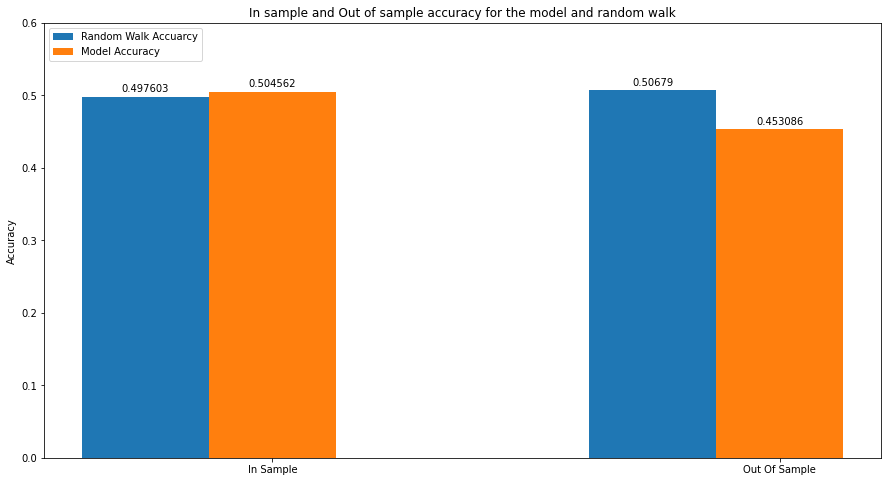

In [12]:
import matplotlib.pyplot as plt

species = ("In Sample", "Out Of Sample")
penguin_means = {
    'Random Walk Accuarcy': (a, c),
    'Model Accuracy': (b, d)
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Accuracy')
ax.set_title('In sample and Out of sample accuracy for the model and random walk')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left')
ax.set_ylim(0, 0.60)
# plt.grid()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

From Q3's graph we can see that MOdel Accuracy is higher than random walk accuracy fot In sample. Meanwhile, random walk accuracy is higher than model accuracy for out of sample.